# PDE-Learning of fermion dynamics in the Fermi-Hubbard model


In [76]:
%pylab inline
%load_ext autoreload
%autoreload 2

import sys
import time
import numpy as np 
sys.path.insert(0, "../")

from PDE_search import *
from utils import save_dict, load_dict
from utils import generalized_euler_solver, get_euler_term_from_descr, extract_v

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# In this example we consider fermion dynamics in 1D spinless Ferrmi-Hubbard model with the Hamiltonian:
$$ H = -J \sum_i (c^{+}_i c_{i+1} + c^+_{i+1} c_i) + U \sum_i n_i n_{i+1}- \mu \sum_i n_i,$$
where $J$ is the hopping coefficient, $c^+_i$ ($c_i$) is the creation (annihilation) fermion operator, $U$ is the fermion-fermion interaction strength and $\mu$ is the chemical potential of the fermion gas. 

## Load the data for quench dynamics in a strongly interacting Fermi-Hubbard model (J=0.5, U=2)

In [156]:
data_dict = load_dict(f'./data/fermi-hubbard_J=0.5_U=2.0_L=100.npy')

## Extract $\rho$ and $v$

In [137]:
bc = 'open'
start, stop = 0, -1

rho = data_dict['n']
t = data_dict['t']
v = data_dict['v']

In [138]:
dt = t[1]-t[0]
dx = x[1]-x[0]
m, n = rho.shape

print('dt: ', dt, 'dx: ', dx)
print('Dataset dimensions: ', rho.shape)
print('Xmax, Tmax: ', x[-1], t[-1])

dt:  0.25 dx:  1
Dataset dimensions:  (250, 100)
Xmax, Tmax:  99 62.5


## Visualize data

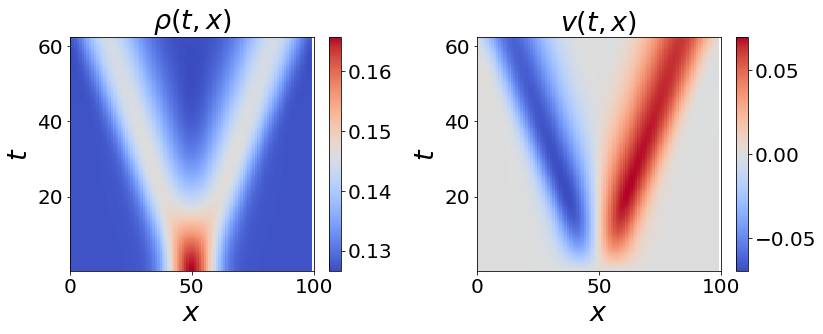

In [139]:
xx, tt = np.meshgrid(x, t)

fig, ax = plt.subplots(1, 2, figsize = (12, 5));
plt_rho = ax[0].pcolormesh(xx, tt, rho, cmap='coolwarm', rasterized=True);
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
ax[0].set_title(r'$\rho(t, x)$')
plt.colorbar(plt_rho, ax=ax[0])

plt_v = ax[1].pcolormesh(xx, tt, v, cmap='coolwarm', rasterized=True);
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'$v(t, x)$')
plt.colorbar(plt_v, ax=ax[1])
fig.tight_layout(pad=2.0)

## Build Library of Candidate Terms

We first differentiate the data along the spatial and temporal directions and construct a library of terms including nonlinearities and partial derivatives.  The matrix $\Theta(\bf U)$ is constructed so that each column is a potential term in the PDE, listed below.

In [150]:
rhot = TotalFiniteDiff_t(rho, dt).reshape((n*m,1))
vt = TotalFiniteDiff_t(v, dt).reshape((n*m,1))
vx = TotalFiniteDiff(v, dx, 1).reshape((n*m,1))

rho_ = rho.reshape((n*m,1))
v_ = v.reshape((n*m,1))
const = np.ones((n*m, 1))

# Library of terms for rho_t = F(.)
rho_descr = [ 
              'rho_x',
              'v_x',
              'rho_x*v_x',
              'rho*rho_x',
              'v*rho_x',
              'rho*v_x',
              'rho*v*rho_x',
              'rho^2*v_x',    
              'rho^2*v*rho_x',
              'rho^3*v_x',    
              'rho^3*v*rho_x',
              'rho^4*v_x',  
            ]

rho_data = []
for term in rho_descr:
    rho_data.append(get_euler_term_from_descr(term, rho_, v_, x, bc))

rho_data = np.hstack(rho_data)
rho_Theta, rho_descr = build_custom_Theta(rho_data, rho_descr)

# Library of terms for v_t = G(.)
v_descr = [
          'rho_x',
           'v*v_x',
           'rho*v*v_x',
           'rho^2*v*v_x',
           'rho^3*v*v_x',
           'rho^4*v*v_x', 
           'rho^5*v*v_x', 
           'rho*rho_x', 
           'rho^2*rho_x', 
           'rho^3*rho_x',
           'v_xx',
           'rho*v_xx',
           'rho^2*v_xx',
            ]

v_data = []
for term in v_descr:
    v_data.append(get_euler_term_from_descr(term, rho_, v_, x, bc))

v_data = np.hstack(v_data)
v_Theta, v_descr = build_custom_Theta(v_data, v_descr)

In [151]:
print(r"Total number of terms for $\rho_t=F(.)$:", len(rho_descr))
print(r"Total number of terms for $v_t=G(.)$:", len(v_descr))

Total number of terms for $\rho_t=F(.)$: 12
Total number of terms for $v_t=G(.)$: 13


## Search PDE for density: $\rho_t = F(...)$

In [142]:
xi_rho, _ = BruteForceL0(rho_Theta, rhot, rho_descr, 
                         l0_penalty=5e-4, lam_l2=0, 
                         verbose=False, lhs_descr='rho_t')

Best PDE found with BruteForce:
rho_t = (-1.196712 +0.000000i)v*rho_x
    + (-0.989563 +0.000000i)rho*v_x
   
Time elapsed (s): 8.668015003204346


## Search PDE for velocity: $v_t+v v_x = G(...)$
Here we perofrm Brute Force search of the best matching equation

In [152]:
xi_v, _ = BruteForceL0(v_Theta, vt+v_*vx, v_descr, 
                       l0_penalty=5e-3, lam_l2=0, verbose=False, lhs_descr='v_t+v*vx')

Best PDE found with BruteForce:
v_t+v*vx = (-13.443933 +0.000000i)rho*rho_x
    + (0.266556 +0.000000i)v_xx
   
Time elapsed (s): 26.53024697303772


## Compare data and the solution of the inferred hydrodynamic PDE

In [153]:
rho_ev, v_ev = generalized_euler_solver(v_descr, xi_v.real, 
                                        rho[0], v[0], t, x, num_integrator_steps=100,
                                        fix_vvx_term=True)

../utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  rho_ev[step, :] = rho.copy()
../utils.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  v_ev[step, :] = v.copy()


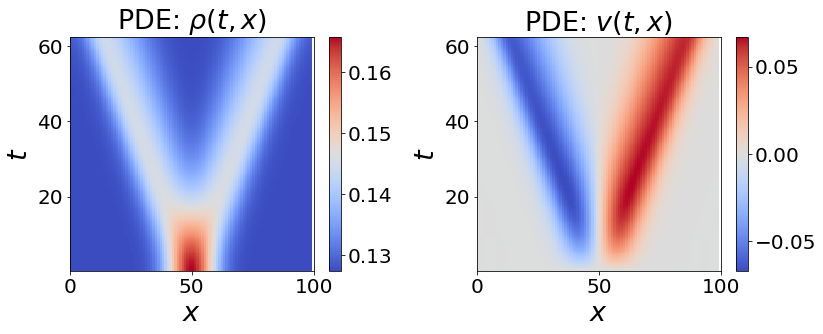

In [154]:
xx, tt = np.meshgrid(x, t)

fig, ax = plt.subplots(1, 2, figsize = (12, 5));
plt_rho = ax[0].pcolormesh(xx, tt, rho_ev, cmap='coolwarm', rasterized=True);
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
ax[0].set_title(r'PDE: $\rho(t, x)$')
ax[0].set_xticks([0, 50, 100])
plt.colorbar(plt_rho, ax=ax[0])

plt_v = ax[1].pcolormesh(xx, tt, v_ev, cmap='coolwarm', rasterized=True);
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'PDE: $v(t, x)$')
ax[1].set_xticks([0, 50, 100])
plt.colorbar(plt_v, ax=ax[1])
fig.tight_layout(pad=2.0)

### Let's look at the individual time snapshots: data vs PDE

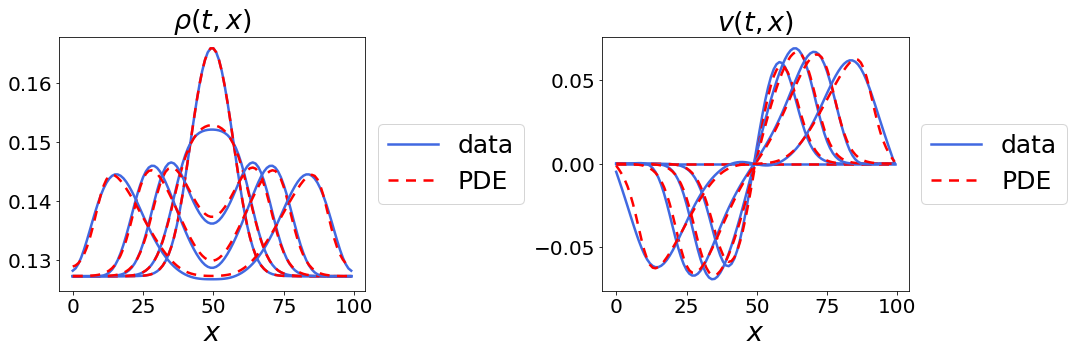

In [183]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));

time_points = [0, 50, 100, 150, -1] 
for i, indx in enumerate(time_points):
    if i == 0:
        label1, label2 = 'data', 'PDE'
    else:
        label1, label2 = '', ''
    ax[0].plot(x, rho[indx, :],
             c='royalblue', label=label1)
    ax[0].plot(x, rho_ev[indx,:], 
             ls='--', c='red', dashes=(4,3), label=label2)
    ax[1].plot(x, v[indx, :],
             c='royalblue', label=label1)
    ax[1].plot(x, v_ev[indx,:], 
             ls='--', c='red', dashes=(4,3), label=label2)


ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set_xlabel(r'$x$')
ax[0].set_title(r'$\rho(t, x)$')

ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set_xlabel(r'$x$')
ax[1].set_title(r'$v(t, x)$')

fig.tight_layout(pad=1.0)
plt.show()

We found Navier-Stocks-like equation for the interacting fermion gas:
$$\begin{cases}
\rho_t+(\rho v)_x = 0,\\
v_t+v v_x + \kappa(U)\rho \rho_x = \nu v_{xx}
\end{cases}
$$

## Let's extract the pressure term renormalization coefficient $\kappa (U)$
We fix the form of equation and find the coefficients via regression.

In [186]:
# ---------------------------------------------
# Define the list of values of the interaction strength U
# ---------------------------------------------
U_list = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0]
kappa_list, vF_list, J = [], [], 0.5
for U in U_list:
    data_dict = load_dict(
        f'./data/fermi-hubbard_J=0.5_U={U}_L=100.npy')
    rho = data_dict['n']
    v = data_dict['v']
    t = data_dict['t']
    x = data_dict['x']
    m, n = rho.shape
    
    dt = t[1] - t[0]
    dx = x[1] - x[0]

    rho_ = rho.reshape((n*m,1))
    v_ = v.reshape((n*m,1))
    
    # compute derivatives from data
    rhot = TotalFiniteDiff_t(rho, dt).reshape((n*m,1))
    rhox = TotalFiniteDiff(rho, dx, 1).reshape((n*m,1))    
    vt = TotalFiniteDiff_t(v, dt).reshape((n*m,1))
    vx = TotalFiniteDiff(v, dx, 1).reshape((n*m,1))    
    vxx = TotalFiniteDiff(v, dx, 2).reshape((n*m,1))
    
    # Fix the form of the PDE and extract cooefficient kappa(U) via linear regression 
    X = np.hstack([rho_*rhox, vxx])
    xi = np.linalg.lstsq(X, vt+v_*vx)[0]
    # Add kappa(U) to the list
    kappa_list.append(xi[0])
    # Compute Fermi velocity in the non-interacting limit, vF = pi*rho_0
    vF = np.pi*rho[0, 0]
    vF_list.append(vF)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Here we compare the dependence of $\kappa(U)$ with the prediction of the Tomonaga-Luttinger (TL) theory.
According to the TL theory the Fermi velocity is renormalized as $v_{eff}(U) = v_{F0}\sqrt{1 + \frac{U}{2\pi v_{F0}}}$, where $v_{F0}=\pi\rho_{0}$ is the Fermi velocity in the non-interacting limit ($U\to 0$). [1] Therefore, we expect that the pressure renormalization coefficient depends on the interaction parameter as $\frac{\kappa(U)}{\kappa_0} = 1 + \frac{U}{2\pi v_{F0}}$, where $\kappa_0=\kappa(U\to 0)$ 

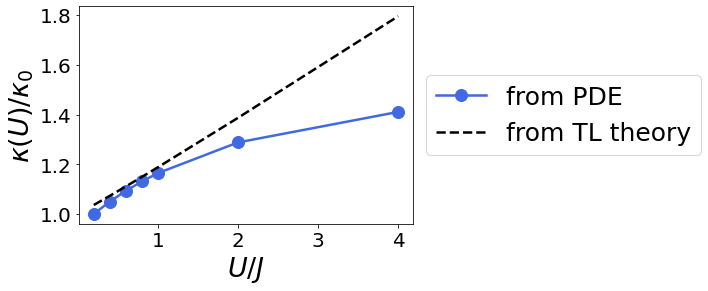

In [190]:
# -----------------------------
# convert lists to numpy arrays
# -----------------------------
U_list, vF_list = np.array(U_list), np.array(vF_list)

# -----------------------------
# plot kappa(U) vs U/J
# -----------------------------
plt.plot(U_list/J, np.abs(kappa_list/kappa_list[0]), c='royalblue', 
         marker='o', ms=12, label='from PDE');
plt.plot(U_list/J, 1+U_list/(2*np.pi*vF_list), c='k', ls='--', label='from TL theory')
plt.xlabel(r'$U/J$')
plt.ylabel(r'$\kappa (U)/\kappa_0$')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

### Bibliography
[1] A. M. Tsvelik, Quantum field theory in condensed matter physics (Cambridge university press, 2007).